# Analysis of the coding mutations

Created: **17/07/18**  
Last modified: **26/07/18**

**Goal:** further analysis on the RAW data `all_IMPACT_mutations_180508.txt` using the filtered dataset obtained at the end of `first_analysis.ipynb [Pierre]`, enriched with the annotations from the `add_features()` function obtained at the end of  `annotating.ipynb [Pierre]`.
This notebook is divided in two (independant) parts:
* **1. The `class` feature: somatic vs non-somatic**: introduce a new feature to class the mutations as somatic or non-somatic, and compare these two classes (frequency_in_normals, vaf, strand bias, Kaviar_AF, cosmic count). The `synonymous_SNV` are excluded from this study, which only focus on the coding mutations.  
* **2. The `mut_key` feature: study of shared mutations**: study the reccurence  of mutations and the possible inconsistent labels. This study includes the `synonymous_SNV` mutations.

**Refs:**
* [CodingDistributions.Rmd [Elsa]](
https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180510_elsa/CodingDistributions.Rmd)
* `first_analysis.ipynb` [Pierre]
* `annotating.ipynb` [Pierre]
* `custom_tools.R` [Pierre]

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-class-feature:-somatic-vs-non-somatic" data-toc-modified-id="The-class-feature:-somatic-vs-non-somatic-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>class</code> feature: somatic vs non-somatic</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals" data-toc-modified-id="Comparison-of-the-frequency_in_normals-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code></a></span></li><li><span><a href="#Comparison-of-the-t_vaf" data-toc-modified-id="Comparison-of-the-t_vaf-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of the <code>t_vaf</code></a></span></li><li><span><a href="#Comparison-of-the-strand-bias" data-toc-modified-id="Comparison-of-the-strand-bias-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of the strand bias</a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-key-feature:-study-of-shared-mutations" data-toc-modified-id="The-key-feature:-study-of-shared-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>key</code> feature: study of shared mutations</a></span><ul class="toc-item"><li><span><a href="#Studying-the-reccurence-of-mutations" data-toc-modified-id="Studying-the-reccurence-of-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Studying the reccurence of mutations</a></span></li><li><span><a href="#Study-of-the-proportion-of-inconsistent-features" data-toc-modified-id="Study-of-the-proportion-of-inconsistent-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Study of the proportion of inconsistent features</a></span></li><li><span><a href="#Sudy-of-the-reccurent-mutations" data-toc-modified-id="Sudy-of-the-reccurent-mutations-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sudy of the reccurent mutations</a></span></li></ul></li></ul></div>

***

In [37]:
source("custom_tools.R") # custom tools functions made on purpose
setup_environment()

In [38]:
impact <- get_cleaned_impact()
impact <- add_features(impact, Kaviar_AF = TRUE, cosmic_count = TRUE)

## The `class` feature: somatic vs non-somatic

The `synonymous_SNV` are excluded from this study, which focus only on the coding mutations. Anyway most of them were classified as `UNKNOWN`.

In [39]:
impact <- impact[impact$Consequence != "synonymous_SNV",] # remove the synonymous mutations
nrow(impact)

[1] 199218

### Creating the feature

We remove the mutations curated as `UNKNOWN` and create a new feature `class`:
* A mutation has `class = somatic` if `confidence_class = AUTO_OK | MANUAL_OK`
* A mutation has `class = non-somatic` if `confidence_class = UNLIKELY | OK_NOT_SO` (it is either a germline or an artefact)

In [40]:
impact <- impact[impact$confidence_class != "UNKNOWN",] # keep only the curated mutation
impact$class <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK"] <- "somatic"
addmargins(table(impact$class, impact$confidence_class), margin = 2)

,AUTO_OK,MANUAL_OK,OK_NOT_SO,UNLIKELY,Sum
non-somatic,0,0,348,11089,11437
somatic,181337,6415,0,0,187752


The dataset is highly unbalanced with 11,437 non-somatic mutations ($5.7\%$ of the samples) vs 187,752 somatic mutations ($94.3\%$ of the samples).

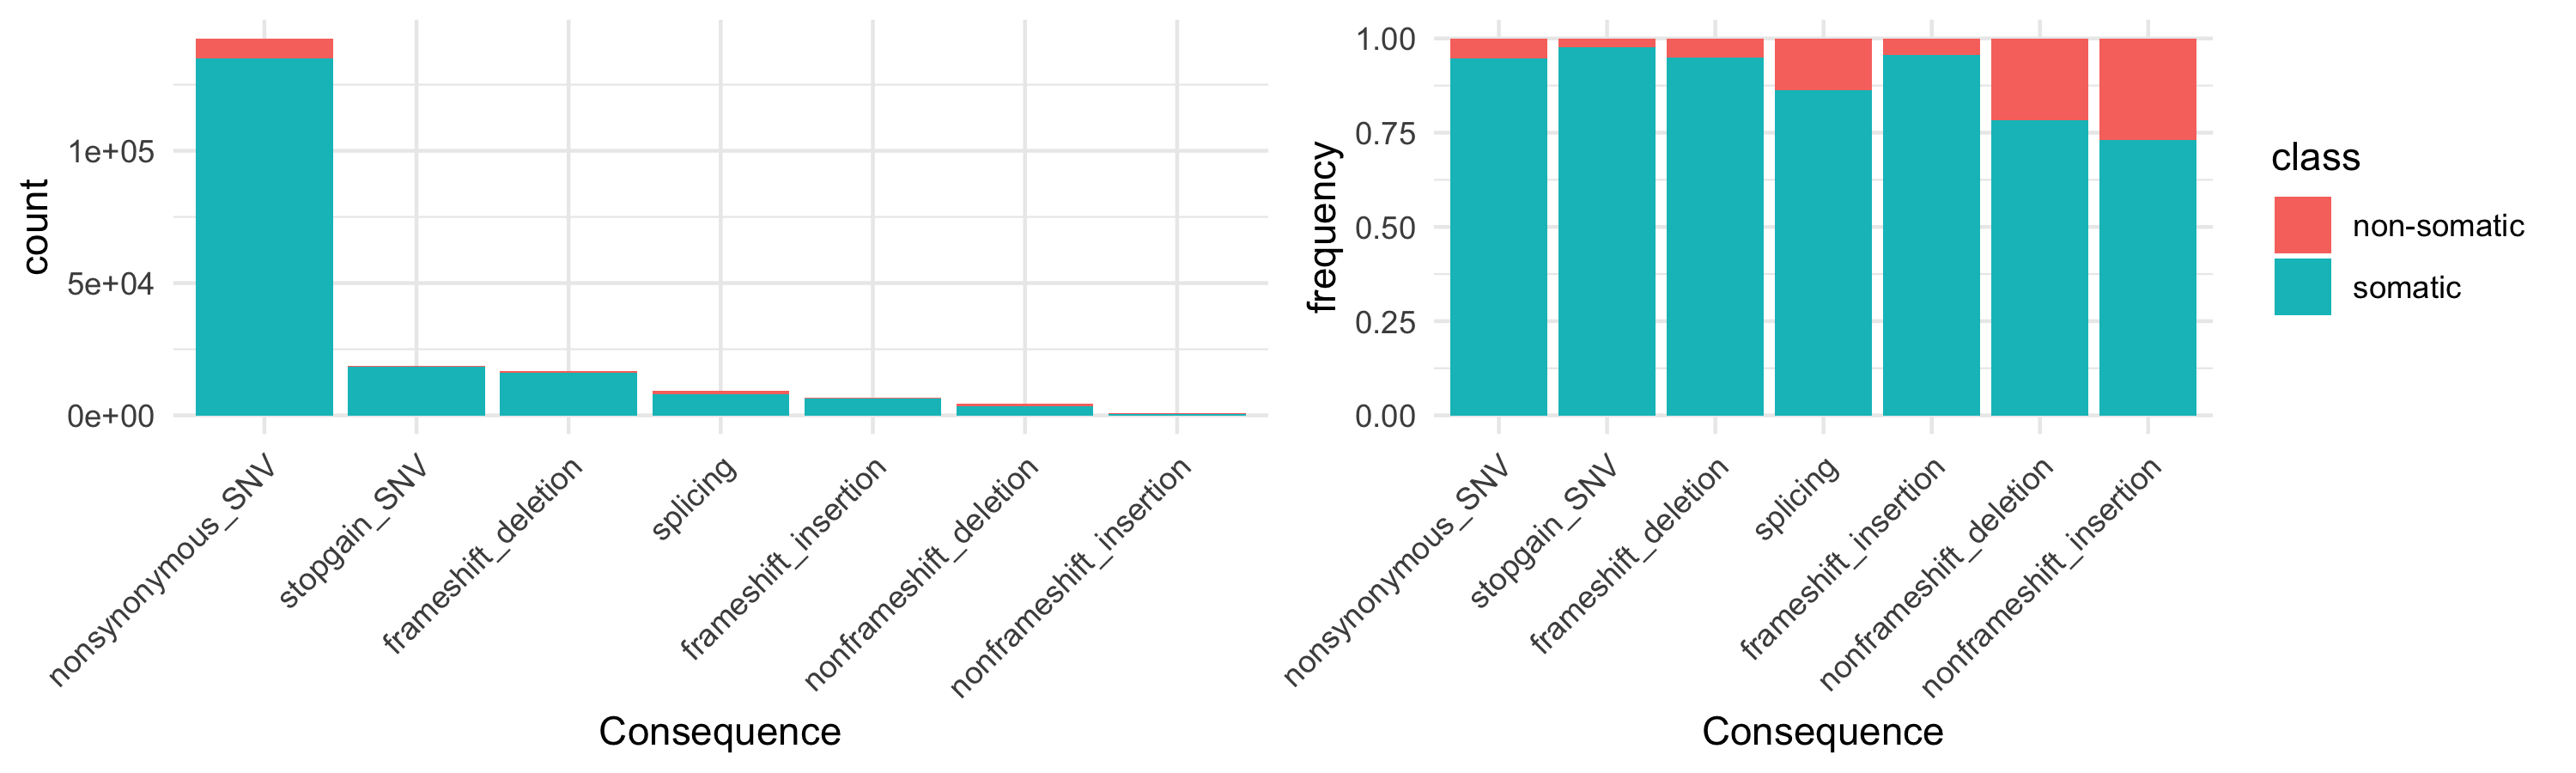

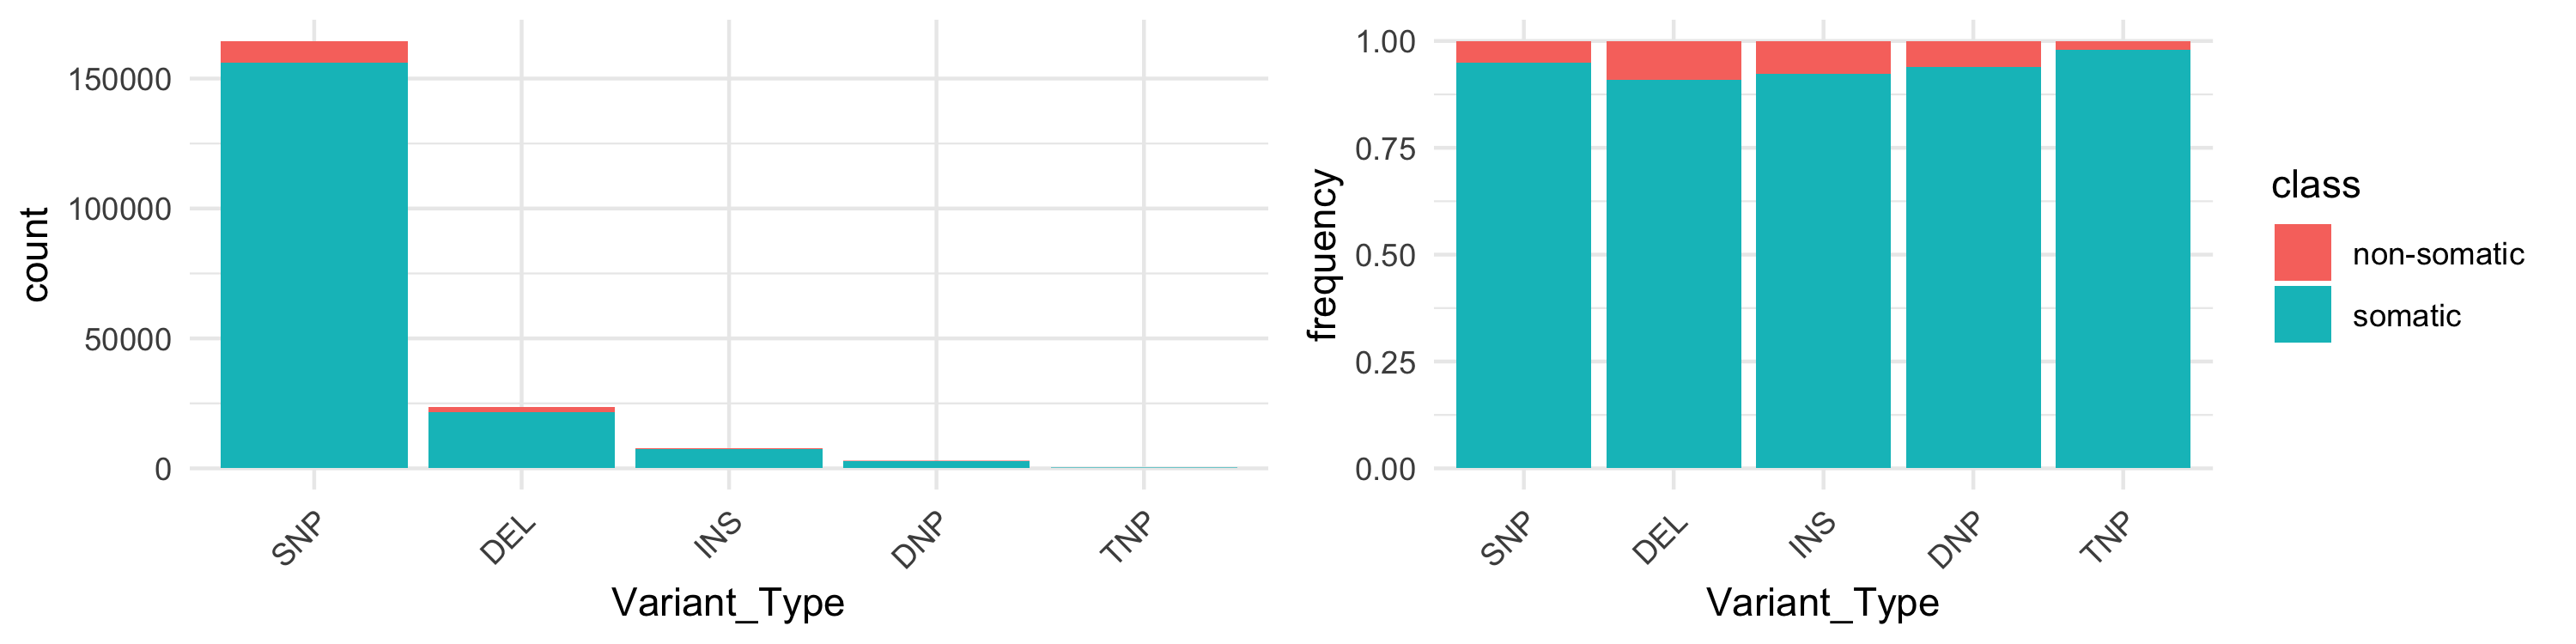

In [5]:
plot_contingency_table_as_histograms(impact, "Consequence", "class")
plot_contingency_table_as_histograms(impact, "Variant_Type", "class", 10, 2.5)

Nothing particularly interesting was found here, it does not seem the mutation `Consequence` or `Variant_Type` features have a clear impact on the `class` of the mutation. We can notice the relatively high amount of `non-somatic` in the `nonframeshift_deletion` and `nonframeshift_insertion` mutations.

### Comparison of the `frequency_in_normals`

Distribution of `frequency_in_normals` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

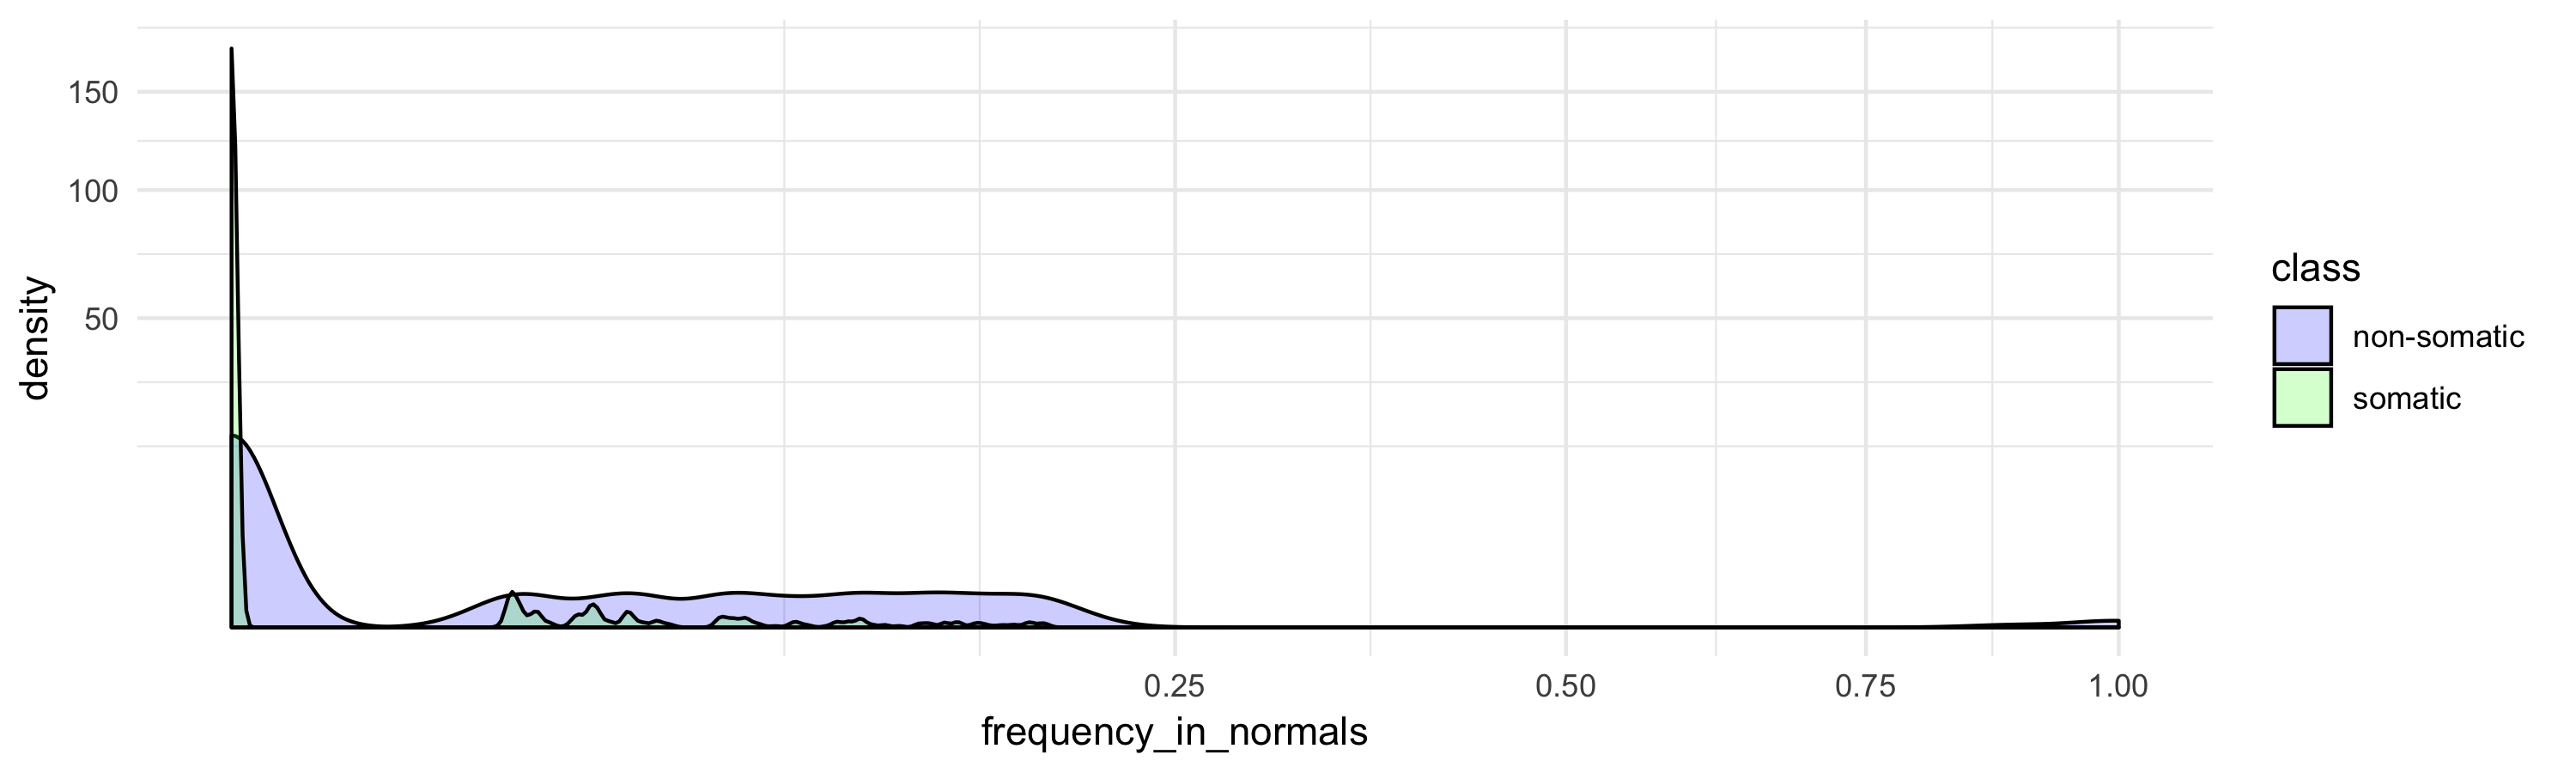

In [6]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(frequency_in_normals, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt()

Overall the non-somatic mutations are, as expected, more present in normals (due to the germline part). However there are some somatic mutations with a not-so-close-to-0 `frequency_in_normals`:

[1] 2077

[1] 175

[1] 0

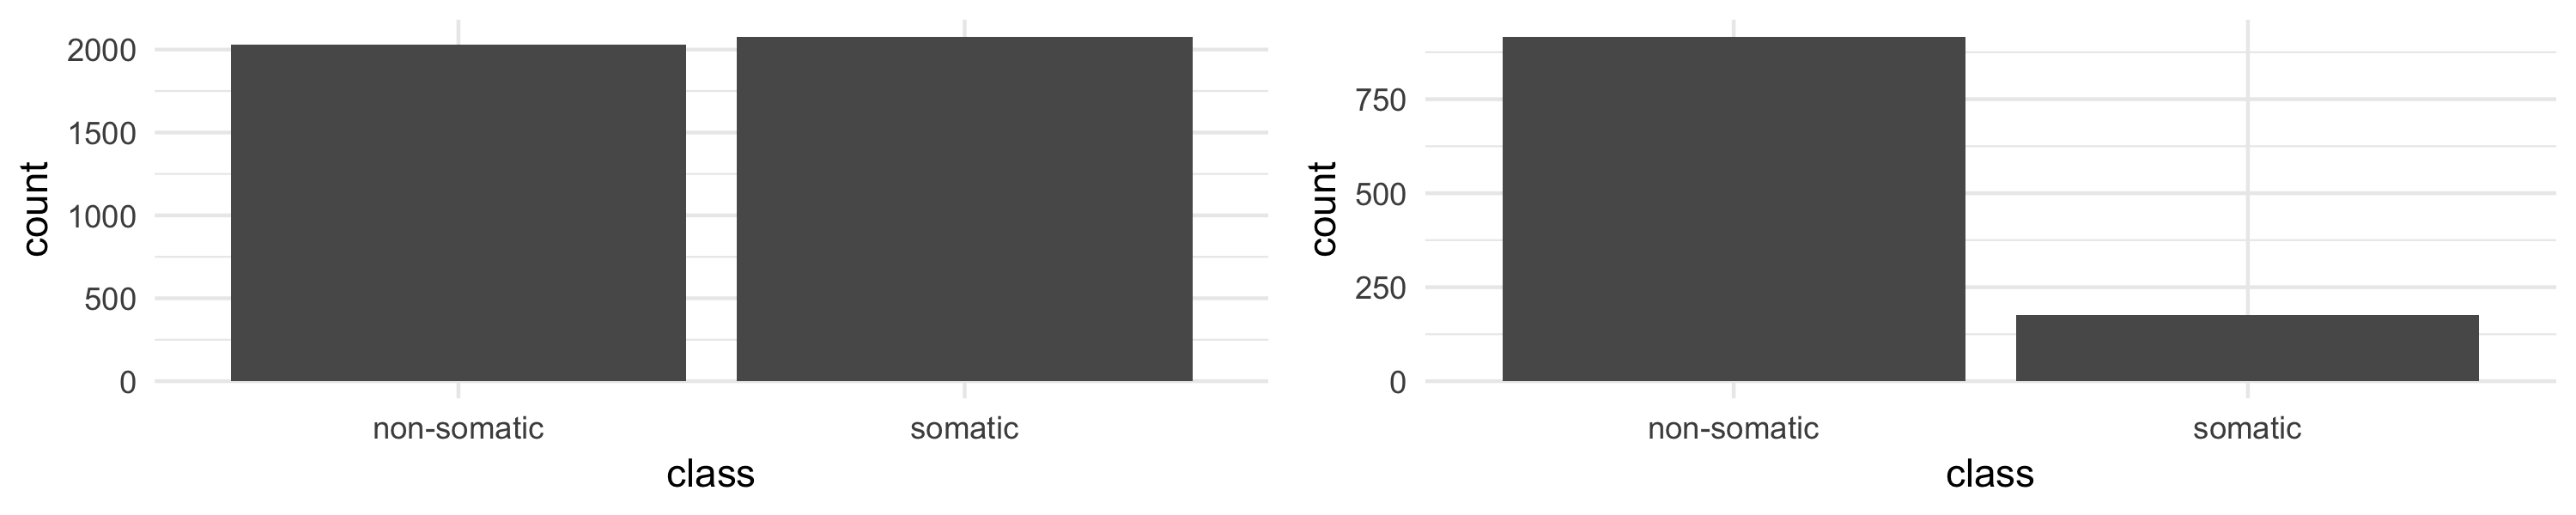

In [7]:
nrow(impact[impact$frequency_in_normals > 0   & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.2 & impact$class == "somatic",])

notebook_plot_size(6, 2)
plot1 <- ggplot(impact[impact$frequency_in_normals > 0  ,]) + geom_bar(aes(class))
plot2 <- ggplot(impact[impact$frequency_in_normals > 0.1,]) + geom_bar(aes(class))
plot_side_by_side(plot1, plot2)

[1] 0.09449 0.21086 0.19390 0.23522 0.08852 0.17115 0.07649 0.48465 0.18056
 [10] 0.04661 0.05618 0.42128 0.12861 0.11822 0.13541 0.06173 0.05528 0.17257
 [19] 0.08104 0.27100 0.13689 0.05085 0.05650 0.20529 0.05917 0.18333 0.29892
 [28] 0.05227 0.06345 0.08434 0.07967 0.12935 0.06148 0.20175 0.25397 0.02874
 [37] 0.06875 0.10301 0.13585 0.10074 0.06057 0.05820 0.10585 0.11026 0.12171
 [46] 0.17563 0.25917 0.10252 0.34409 0.19449 0.10746 0.06383 0.08481 0.07647
 [55] 0.12000 0.15707 0.05931 0.28571 0.16901 0.05274 0.18182 0.08069 0.06337
 [64] 0.06649 0.11255 0.22769 0.06030 0.22422 0.15402 0.11171 0.47968 0.30000
 [73] 0.10870 0.02256 0.08475 0.17857 0.21681 0.21110 0.06135 0.28173 0.38119
 [82] 0.23596 0.15094 0.11828 0.07584 0.14938 0.05085 0.09587 0.16350 0.18770
 [91] 0.46429 0.06404 0.13742 0.06433 0.27778 0.17241 0.11667 0.06818 0.14026
[100] 0.14189 0.07525 0.12731 0.07422 0.08983 0.09584 0.06857 0.05172 0.21315
[109] 0.10117 0.05405 0.07826 0.23429 0.10023 0.24862 0.09091 0.20930 0.09143
[118] 0.09259 0.18966 0.15232 0.06426 0.06167 0.14312 0.12074 0.06024 0.09223
[127] 0.10462 0.08667 0.09899 0.24086 0.21067 0.14765 0.08753 0.10095 0.08378
[136] 0.05152 0.07207 0.06944 0.09091 0.11013 0.22714 0.07024 0.07837 0.17073
[145] 0.15065 0.40000 0.10084 0.18182 0.22078 0.18787 0.19026 0.07422 0.17043
[154] 0.18396 0.20833 0.45714 0.16914 0.12644 0.14402 0.14549 0.26316 0.05645
[163] 0.19608 0.25714 0.02524 0.07895 0.07576 0.11000 0.05855 0.08991 0.58950
[172] 0.09263 0.05586 0.05541 0.06569

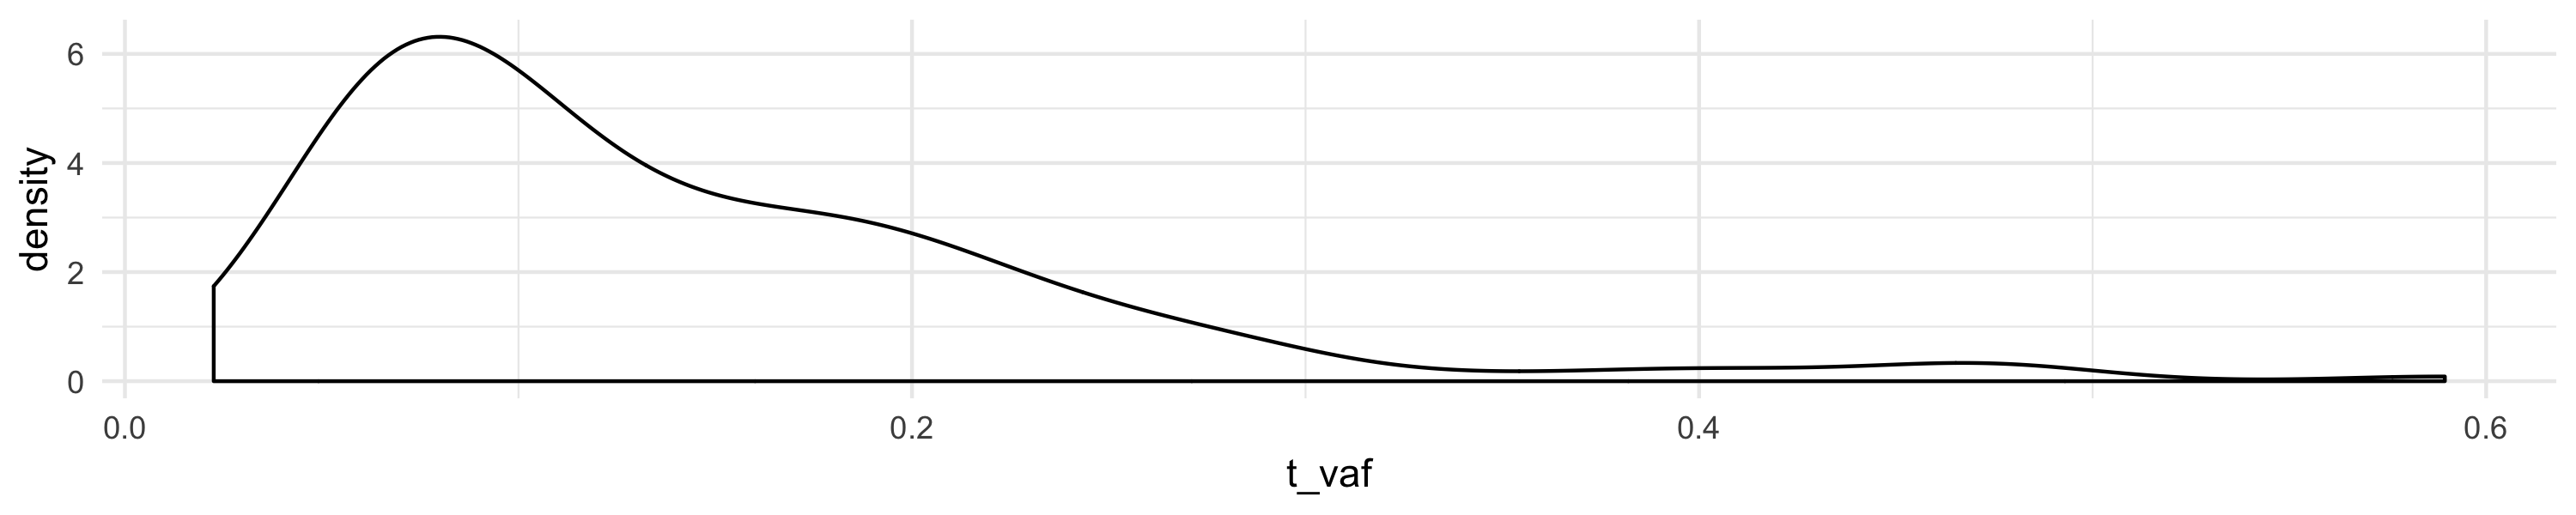

In [43]:
ggplot(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",]) + geom_density(aes(t_vaf))

[1] "Number of different genes:  73"


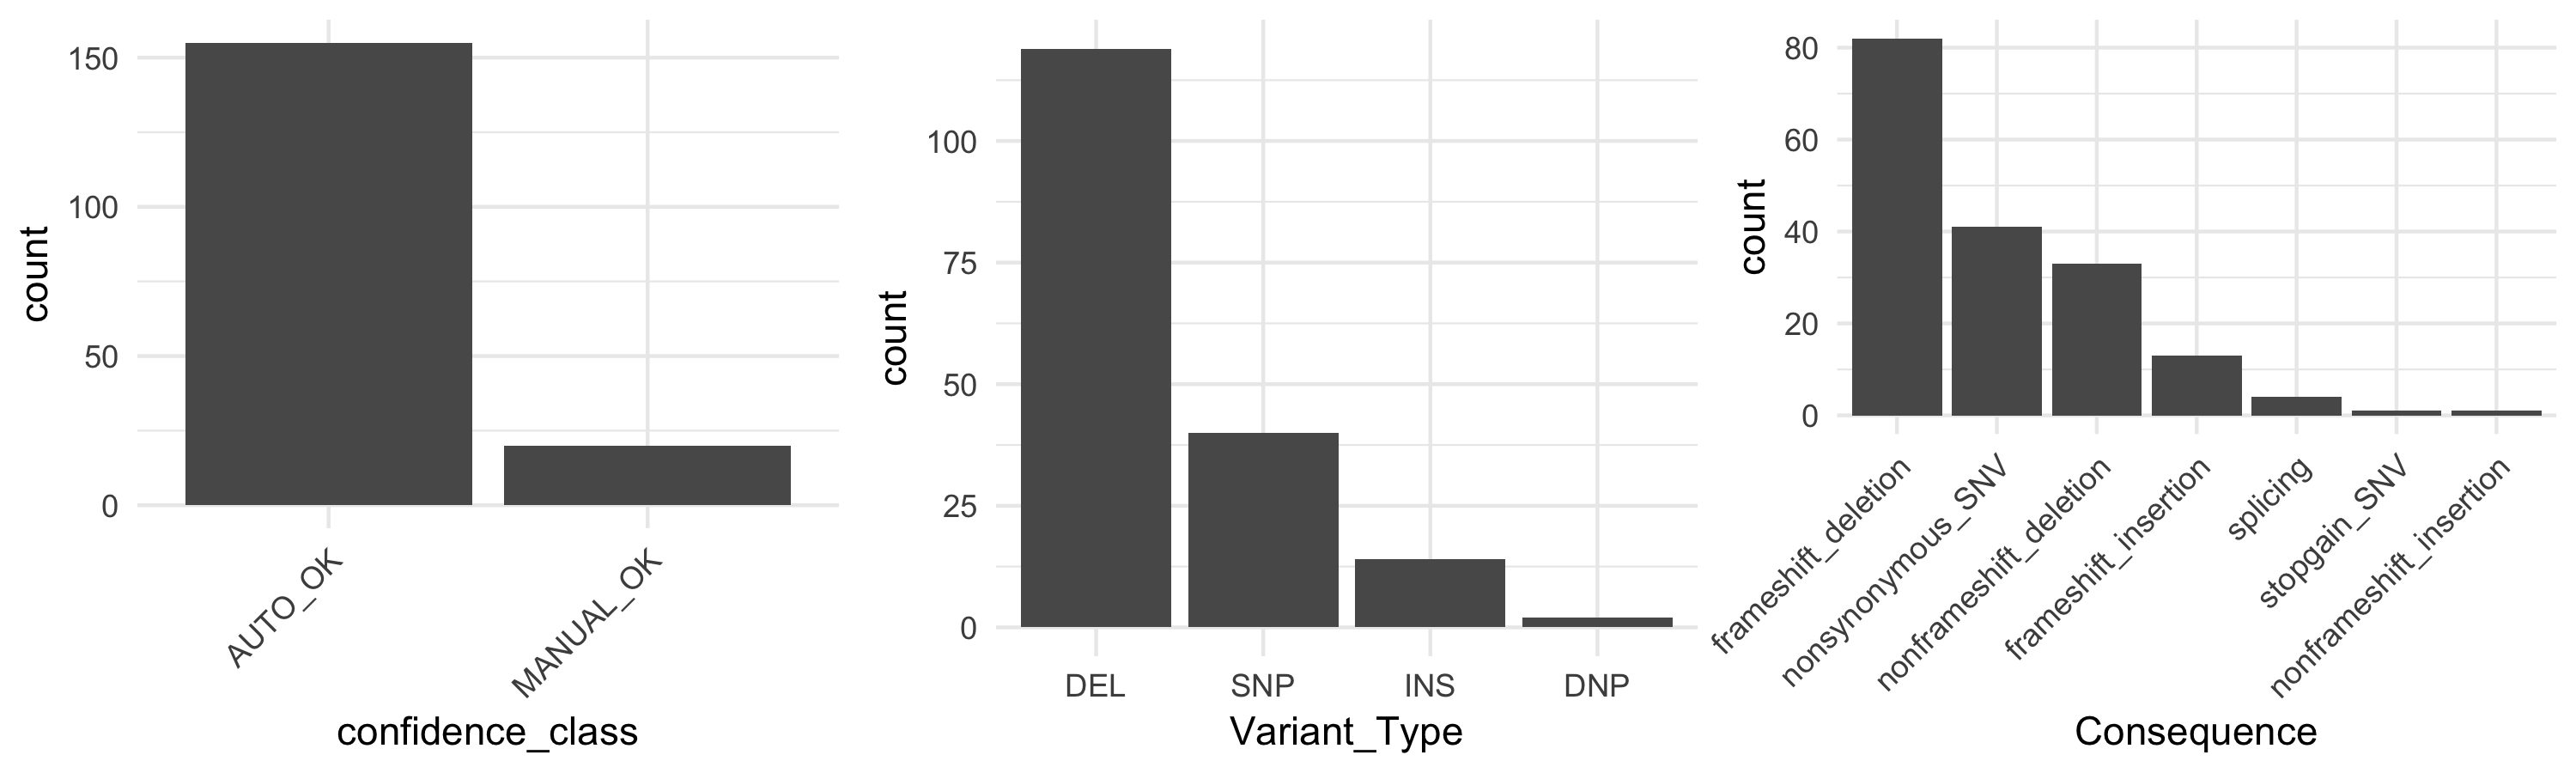

In [8]:
get_possible_correlations(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])

In [9]:
impact[impact$frequency_in_normals > 0.15 & impact$class == "somatic", c("Hugo_Symbol","t_vaf","n_vaf","HGVSp_Short","cosmic_count")]

,Hugo_Symbol,t_vaf,n_vaf,HGVSp_Short,cosmic_count
98250,SMO,0.09449,0.01020,p.L23del,0
102315,KDM5A,0.21086,0.01964,p.G1200Dfs*9,8
114883,KDM5A,0.23522,0.00690,p.G1200Dfs*9,8
119182,ZFHX3,0.08852,0.00000,p.A776V,0
124197,KMT2C,0.17115,0.00521,,2
124206,KMT2D,0.07649,0.01361,p.Q3905L,1
125676,TSC2,0.48465,0.00357,p.X534_splice,0
127316,AR,0.04661,0.00830,p.Q58L,0
129220,RAD50,0.42128,0.00763,p.K722Rfs*14,6
132871,MSH3,0.12861,0.00562,p.K383Rfs*32,16


[1] "Number of different genes:  381"


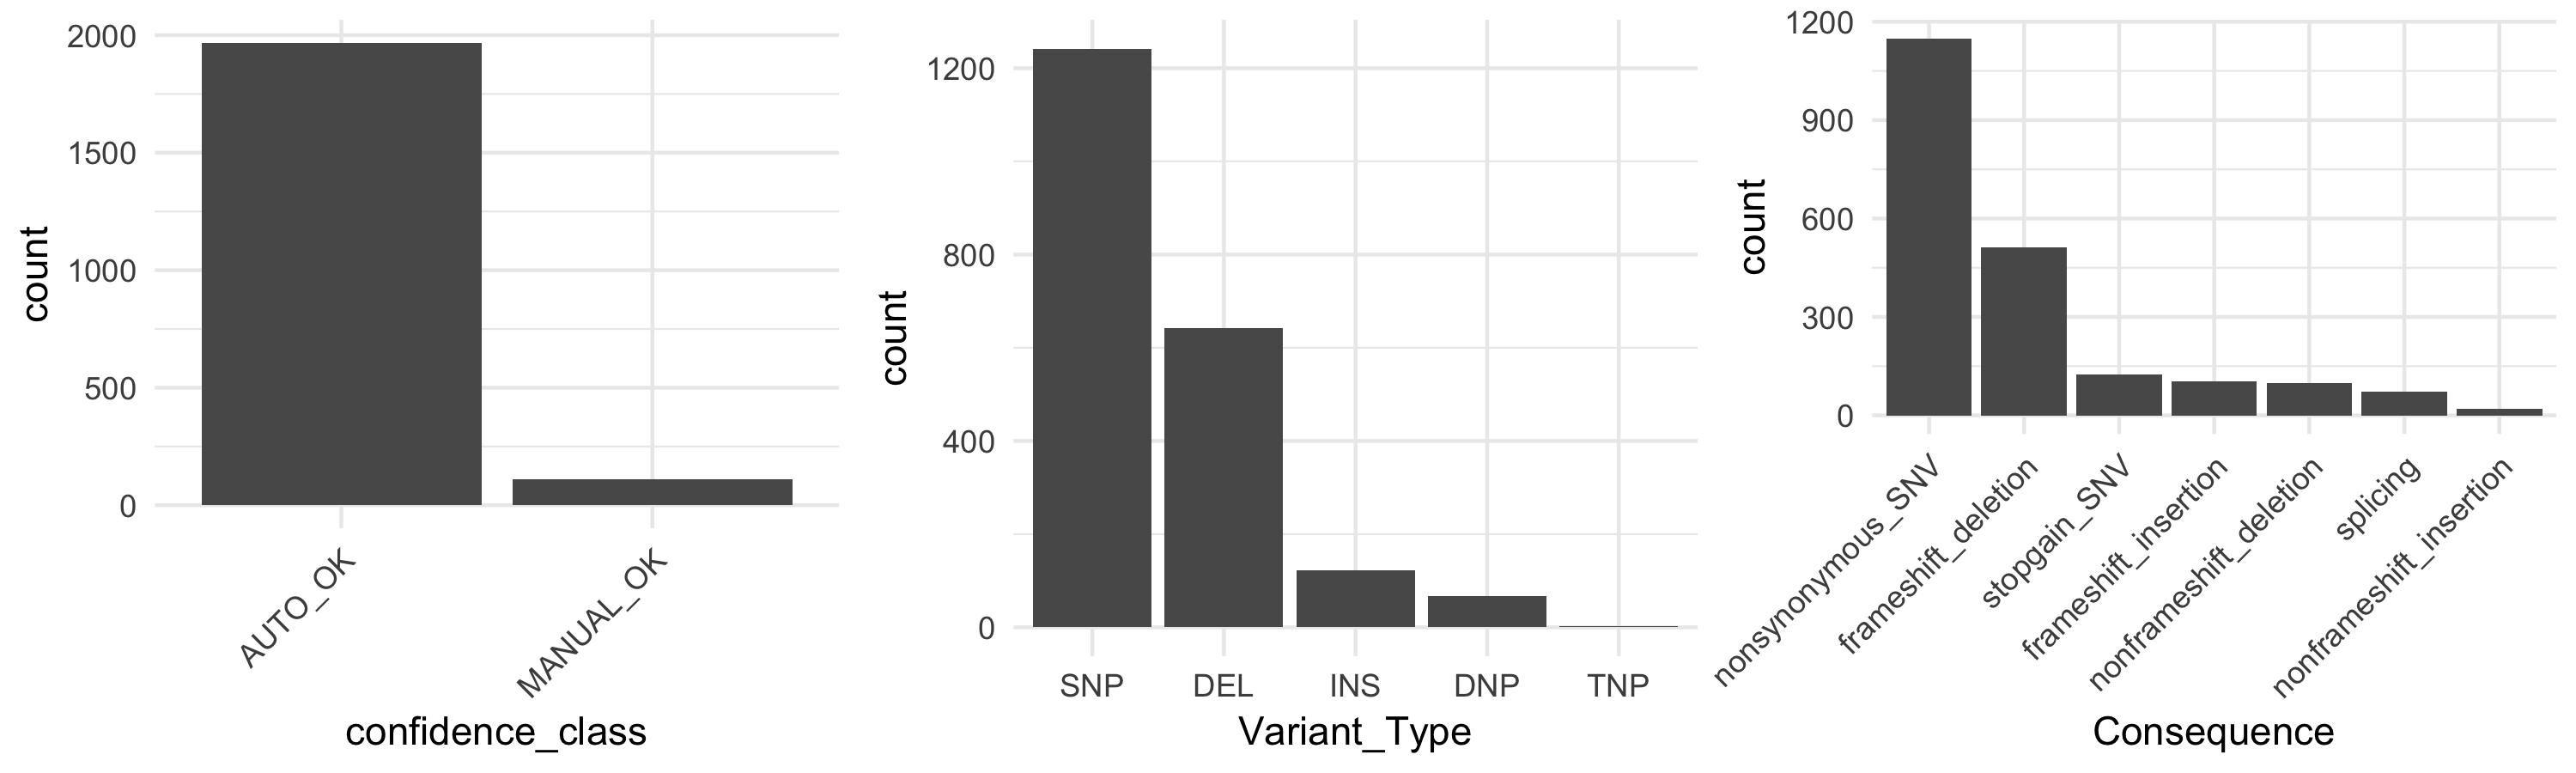

In [10]:
get_possible_correlations(impact[impact$frequency_in_normals > 0 & impact$class == "somatic",])

### Comparison of the `t_vaf`

Distribution of `t_vaf` for the somatic vs non-somatic `class`:

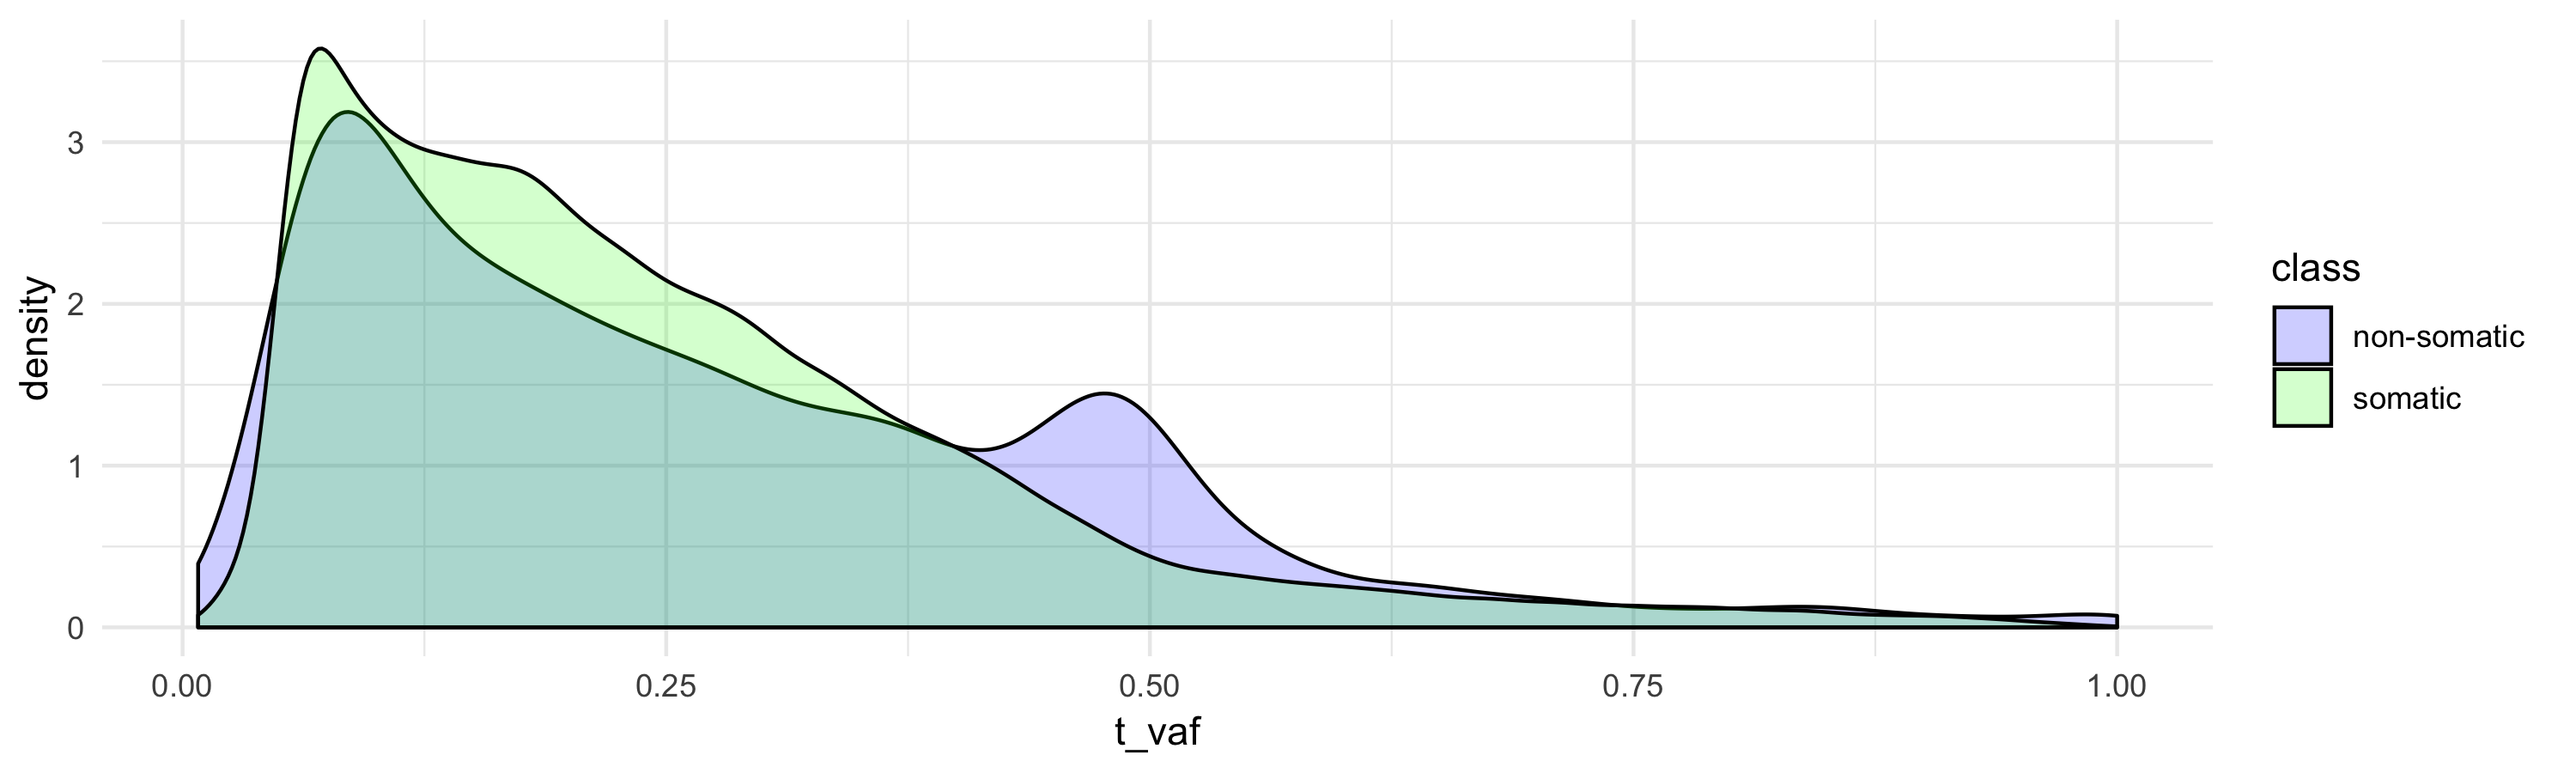

In [11]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(t_vaf, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green"))

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a peak at 0.5 (ie the likely germline calls), and a peak at low VAF (ie the likely artefacts calls)."

### Comparison of the strand bias

We evaluate the `strand_bias` for each mutation as:
$$\text{strand_bias}\ =\ \frac{\min(\text{t_alt_neg_count}, \text{t_alt_plus_count})}
                              {\max(\text{t_alt_neg_count}, \text{t_alt_plus_count})}$$
                              
e.g. the lowest count over the maximum count, thus giving a result between 0 and 1 (1 being a low `strand_bias`, because the count for the neg and pos are the same).

In [12]:
impact$strand_bias <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                      pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `strand_bias` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

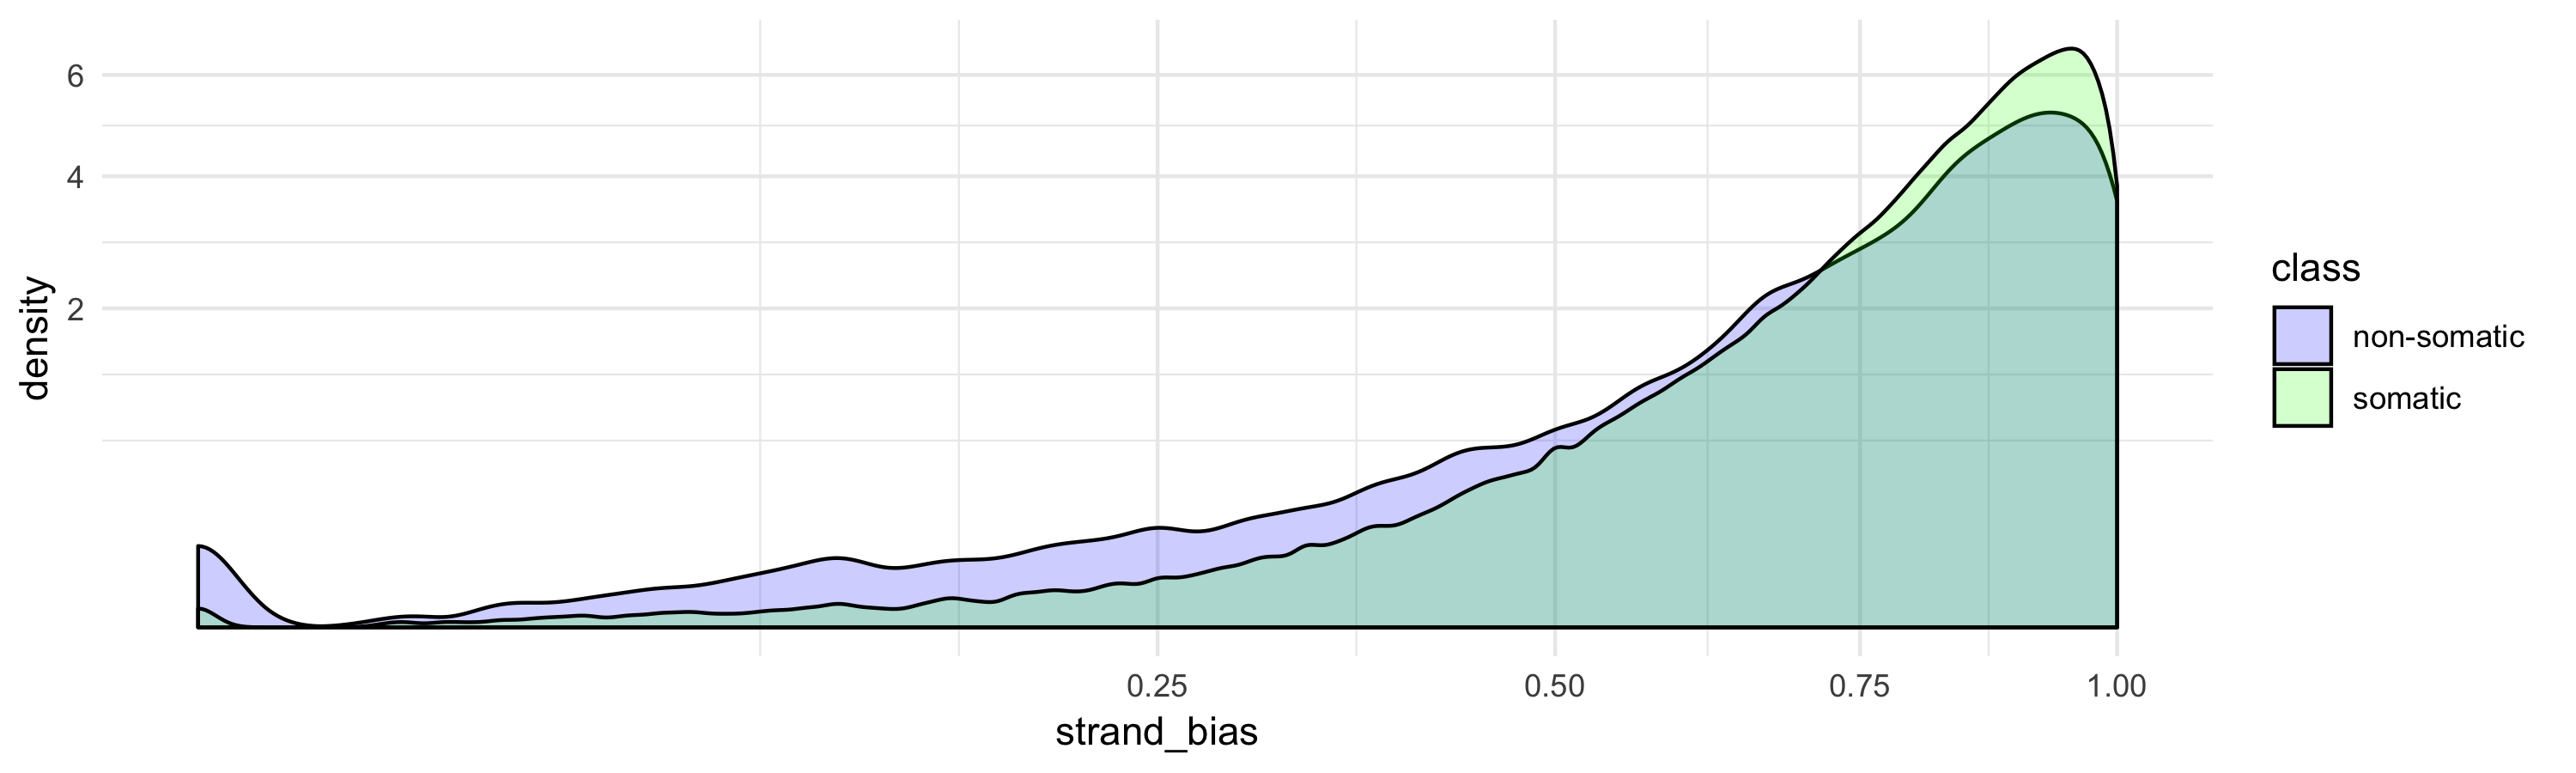

In [13]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(strand_bias, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt()

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a heavier low strand ratio tail (likely from the artefact calls), although this is not very pronounced."

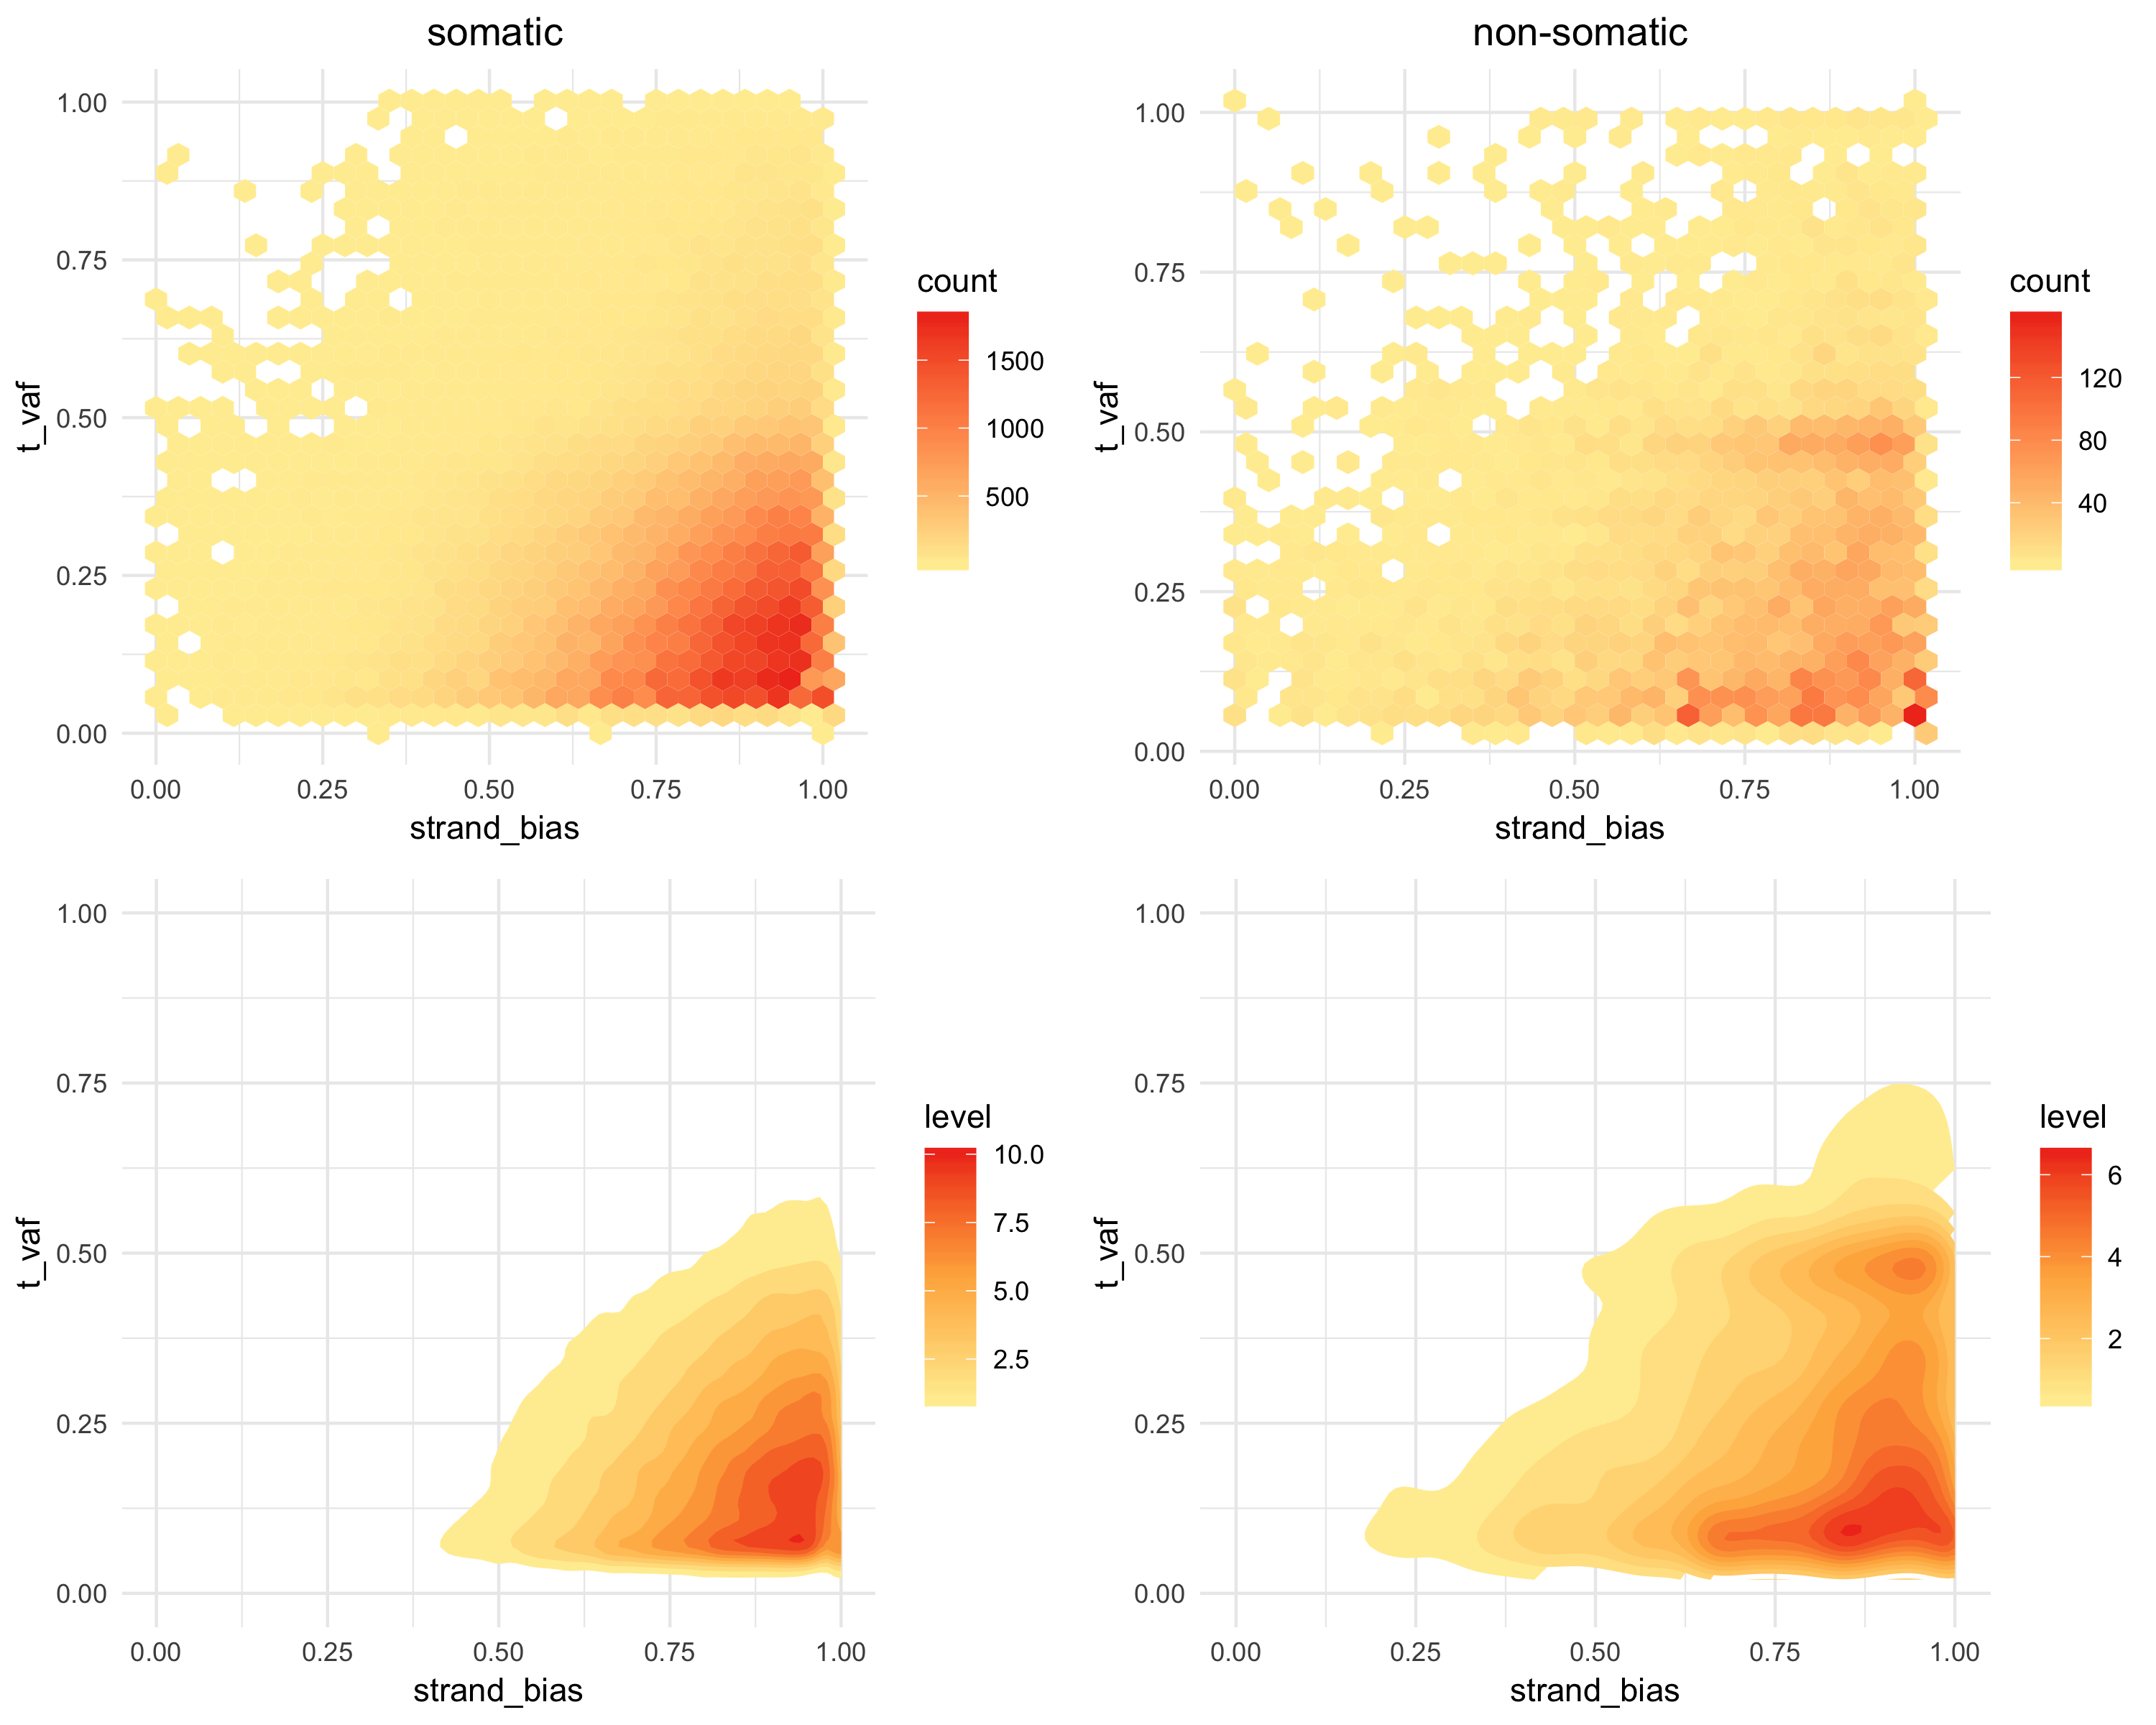

In [14]:
notebook_plot_size(10, 8)
plot1 <- ggplot(impact[impact$class == "somatic",]) + geom_hex(aes(strand_bias, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("somatic") + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$class == "non-somatic",]) + geom_hex(aes(strand_bias, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("non-somatic") + theme(plot.title = element_text(hjust = 0.5))
plot3 <- ggplot(impact[impact$class == "somatic",]) +
         stat_density_2d(aes(strand_bias, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))
plot4 <- ggplot(impact[impact$class == "non-somatic",]) +
         stat_density_2d(aes(strand_bias, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))

plot_grid(plot1, plot2, plot3, plot4, ncol = 2, nrow = 2)

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

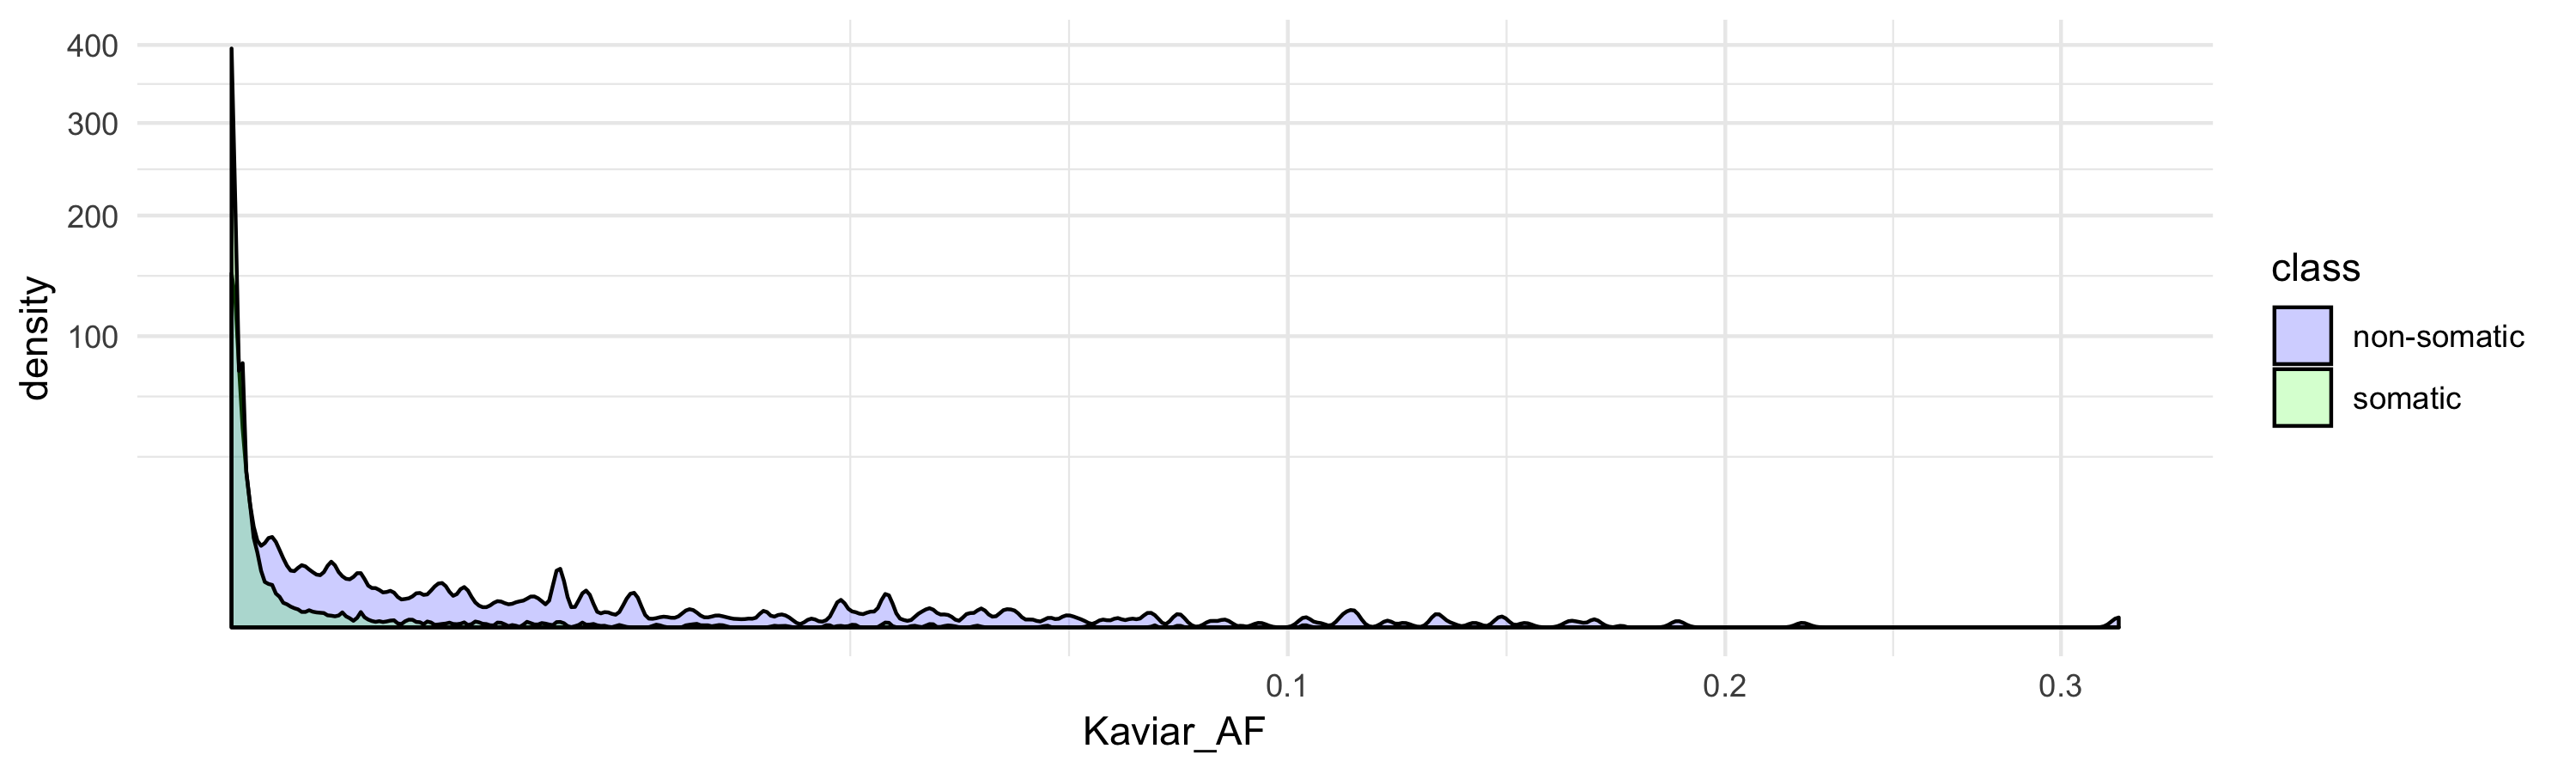

In [15]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(Kaviar_AF, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt() 

What was expected appears clearly, the `non-somatic` class presents a way longer tail on the higher `Kaviar_AF` value (due to the germline calls).

In [16]:
summary(impact$Kaviar_AF[impact$class == "somatic"])
summary(impact$Kaviar_AF[impact$class == "non-somatic"])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 2.638e-05 0.000e+00 1.730e-01 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0028437 0.0001537 0.3192330 

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

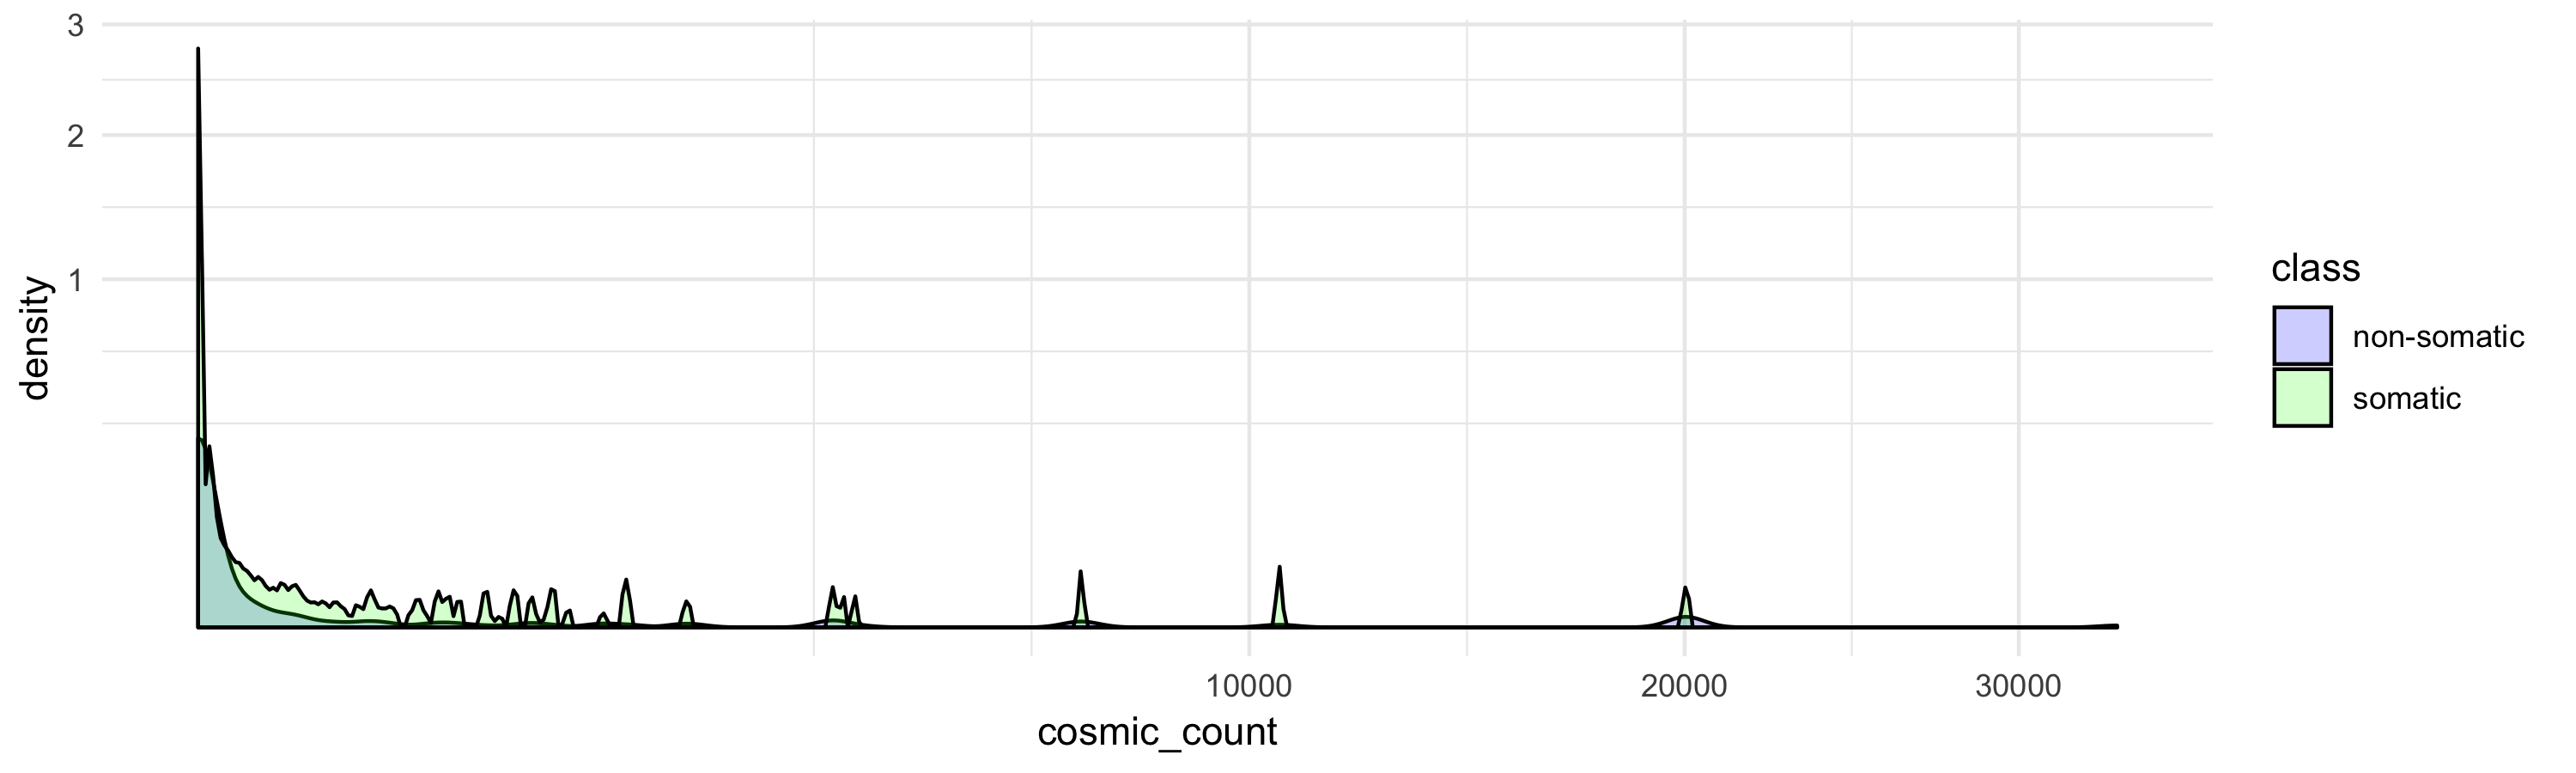

In [17]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(cosmic_count, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt() 

In [18]:
summary(impact$cosmic_count[impact$class == "somatic"])
summary(impact$cosmic_count[impact$class == "non-somatic"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   222.3     1.0 20034.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     0.00    76.19     0.00 33328.00 

## The `key` feature: study of shared mutations

In [19]:
impact <- get_cleaned_impact() # starting from a fresh dataset

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [20]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

[1] 178089

### Studying the reccurence of mutations

In [21]:
key_info <- as.data.frame(table(impact$mut_key))
colnames(key_info) <- c("mut_key", "count")
head(key_info)

mut_key,count
1_108206648_AGAAGTTG_GAAGTTGT,1
1_11167549_A_G,1
1_11168249_G_A,1
1_11168271_G_A,1
1_11168272_A_G,1
1_11168276_C_G,1


In [22]:
for (threshold in c(2, 3, 5, 10)) {
    
    n_keys_shared <- nrow(key_info[key_info$count >= threshold,])
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples",
                  100 * n_keys_shared / nrow(key_info),
                  n_keys_shared,
                  threshold))
}

[1] "16% (28556) of the keys are shared by at least  2 samples"
[1] " 5% ( 9124) of the keys are shared by at least  3 samples"
[1] " 2% ( 2711) of the keys are shared by at least  5 samples"
[1] " 1% (  935) of the keys are shared by at least 10 samples"


Distribution of the mutations key count for the keys present in 2 or more samples (warning this is a sqrt x and y scale):

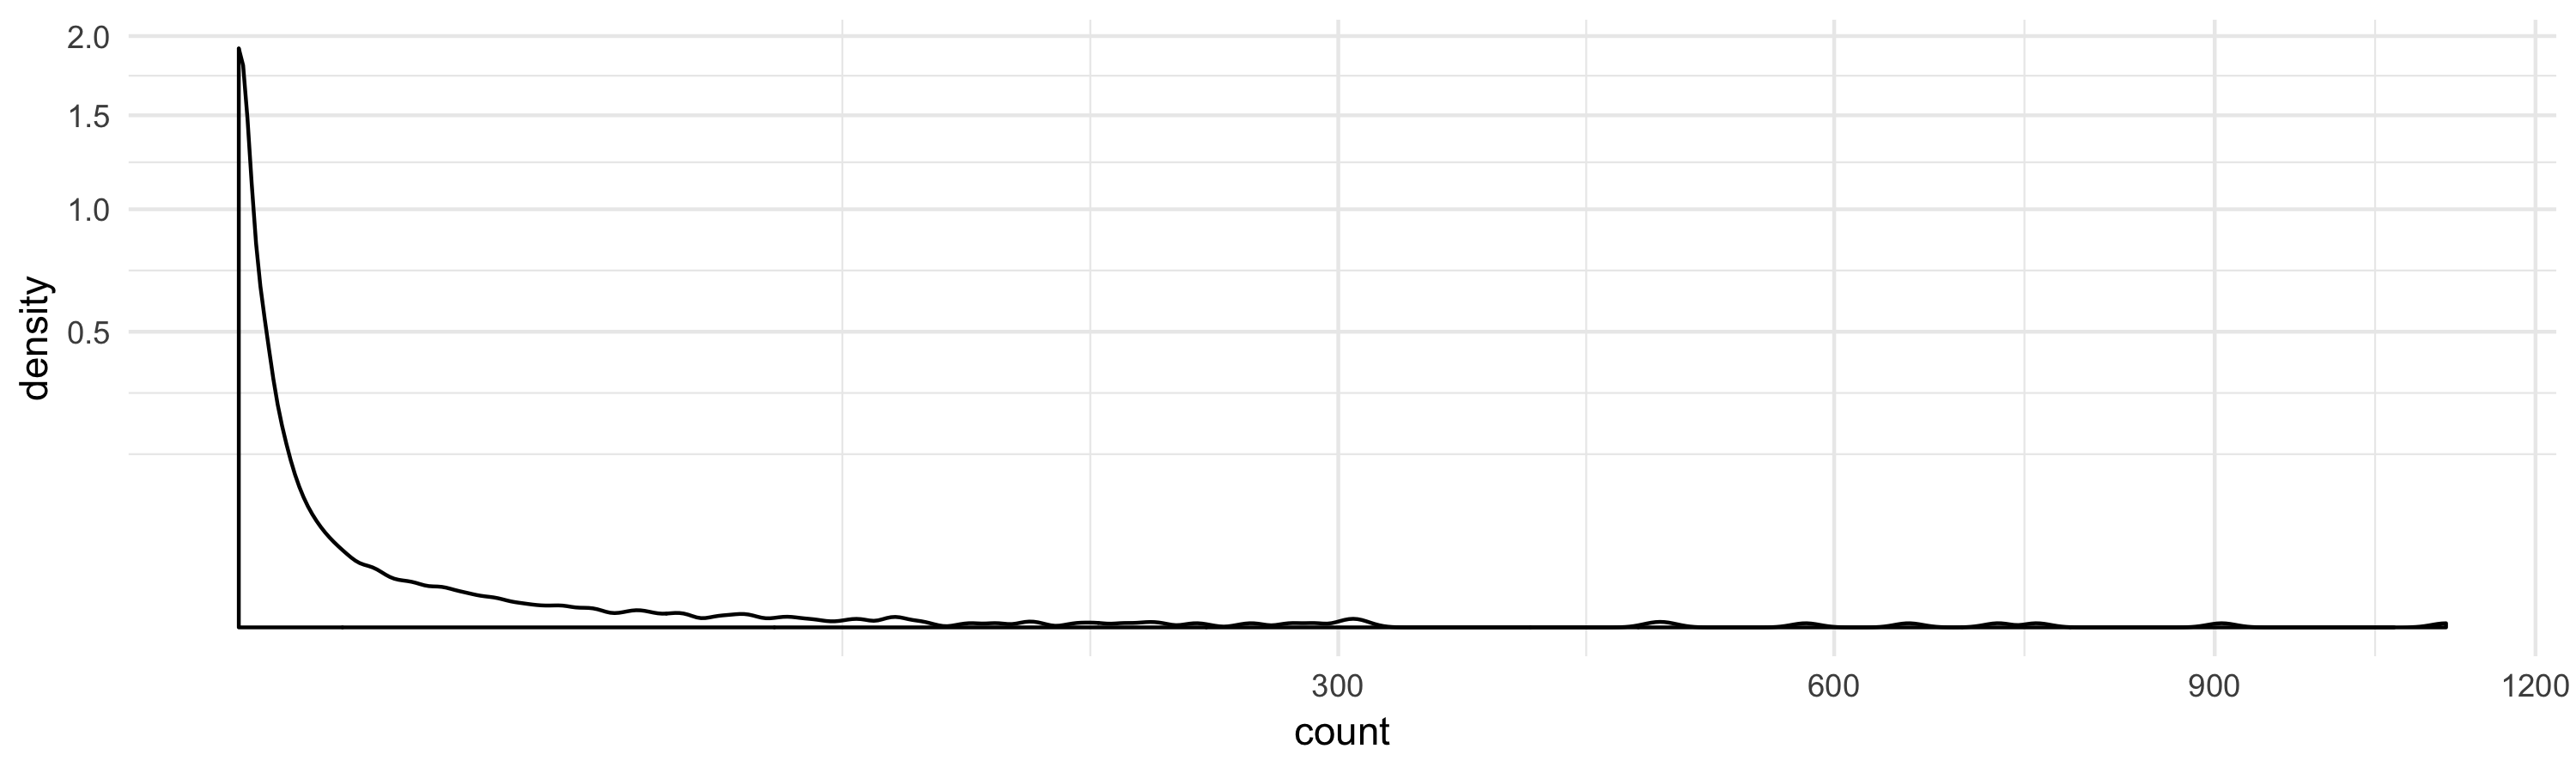

In [23]:
repeated_key <- key_info[key_info$count >= 2,] # keys shared by at least 2 samples
notebook_plot_size(10, 3)
# high adjust to counterpart the non-existing counts which create sharp variations
ggplot(repeated_key) + geom_density(aes(count), adjust = 5) + scale_y_sqrt() + scale_x_sqrt()

### Study of the proportion of inconsistent features

The mutations sharing the same key should have the same following features values: `Hugo_Symbol`, `End_Position`, `Consequence`, `Variant_Type`, `cDNA_change`, `HGVSp_Short`, `confidence_class`, `frequency_in_normals`

We evaluate the number of keys which have 2 or more feature values for a given feature (e.g. the number of keys with inconsistent labels for the given feature):

In [24]:
# We group the mutations with the same key, keeping only the keys that are shared by two or more samples
impact_by_key <- impact[impact$mut_key %in% repeated_key$mut_key,] %>% group_by(mut_key)

for (feature_name in c("Hugo_Symbol", "End_Position", "Variant_Type", "Consequence",
                       "cDNA_change", "HGVSp_Short", "confidence_class")) {
    
    # get the number n of unique feature values per key, count the rows where n != 1
    n_inconsistant_labels <- nrow(impact_by_key %>% summarise(n = length(unique(!! sym(feature_name)))) %>%
                                                    filter(n > 1))
    
    print(sprintf("%16s: %.2f%% (%4d) keys with inconsistent labels",
                  feature_name,
                  n_inconsistant_labels / nrow(impact) * 100,
                  n_inconsistant_labels))
}

[1] "     Hugo_Symbol: 0.00% (   0) keys with inconsistent labels"
[1] "    End_Position: 0.00% (   0) keys with inconsistent labels"
[1] "    Variant_Type: 0.00% (   0) keys with inconsistent labels"
[1] "     Consequence: 0.00% (   9) keys with inconsistent labels"
[1] "     cDNA_change: 0.03% (  74) keys with inconsistent labels"
[1] "     HGVSp_Short: 0.10% ( 261) keys with inconsistent labels"
[1] "confidence_class: 1.19% (3005) keys with inconsistent labels"


So every `mut_key` has a unique `Hugo_Symbol`, `End_Position` and `Variant_Type` values, this is consistent. For the other features, the results are quite good as well.

#### Further study

**`Consequence`**

In [25]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(a = length(Consequence),
                              n = length(unique(Consequence)),
                              diff = toString(unique(Consequence)),
                              count_per_consequence = toString(table(Consequence)),
                              Hugo_Symbol = toString(unique(Hugo_Symbol))) %>%
                    filter(n > 1))
head(dd)

mut_key,a,n,diff,count_per_consequence,Hugo_Symbol
12_49444377_A_-,2,2,"stopgain_SNV, frameshift_deletion","1, 1",KMT2D
16_3817720_-_T,8,2,"splicing, frameshift_insertion","6, 2",CREBBP
16_68849662_-_GT,3,2,"splicing, frameshift_insertion","1, 2",CDH1
19_50919866_G_-,23,2,"frameshift_deletion, splicing","15, 8",POLD1
3_52441465_ATATCCTTTGCTC_T,2,2,"splicing, nonframeshift_deletion","1, 1",BAP1
5_67591145_TACTTGATGT_-,2,2,"splicing, nonframeshift_deletion","1, 1",PIK3R1


In [26]:
table(dd$Hugo_Symbol)


  BAP1   CDH1 CREBBP   EGFR  KMT2C  KMT2D PIK3R1  POLD1 
     1      1      1      2      1      1      1      1 

In [27]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(a = length(cDNA_change),
                              n = length(unique(cDNA_change)),
                              diff = toString(unique(cDNA_change)),
                              count_per_consequence = toString(table(cDNA_change)),
                             Hugo_Symbol = toString(unique(Hugo_Symbol))) %>%
                    filter(n > 1))
head(dd, 15)

mut_key,a,n,diff,count_per_consequence,Hugo_Symbol
1_27102199_G_A,2,2,"c.4473+1G>A, c.5124+1G>A","1, 1",ARID1A
1_45795028_G_A,2,2,"c.1558C>T, c.1600C>T","1, 1",MUTYH
1_45795032_G_T,2,2,"c.1554C>A, c.1596C>A","1, 1",MUTYH
1_45795084_G_A,11,2,"c.1502C>T, c.1544C>T","8, 3",MUTYH
1_45796865_C_A,2,2,"c.1423G>T, c.1465G>T","1, 1",MUTYH
1_45796880_C_T,2,2,"c.1408G>A, c.1450G>A","1, 1",MUTYH
1_45797106_G_A,2,2,"c.1267C>T, c.1309C>T","1, 1",MUTYH
1_45797198_G_A,2,2,"c.1175C>T, c.1217C>T","1, 1",MUTYH
1_45797228_C_T,3,2,"c.1106G>A, c.1187G>A","2, 1",MUTYH
1_45797502_G_A,2,2,"c.975C>T, c.1017C>T","1, 1",MUTYH


In [28]:
table(dd$Hugo_Symbol)


   APC     AR ARID1A   ATRX   BAP1  BRCA1 CDKN2A CREBBP   EGFR  FOXA1 INPP4B 
     1      2      1      1      1      2      2      1      2      1      1 
   KIT  KMT2A  KMT2B  KMT2C  KMT2D  MUTYH  PBRM1 PIK3R1  PTCH1   PTEN  RBM10 
     1      2      1      6      6     15      1      2      2      3      1 
  TP53 
    19 

In [30]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(a = length(confidence_class),
                              n = length(unique(confidence_class)),
                              diff = toString(unique(confidence_class)),
                              count_per_consequence = toString(table(confidence_class))) %>%
                    filter(n > 1))
head(dd, 15)

mut_key,a,n,diff,count_per_consequence
1_11174395_A_C,4,2,"AUTO_OK, MANUAL_OK","3, 1"
1_11187093_G_A,3,2,"AUTO_OK, MANUAL_OK","2, 1"
1_11190834_C_T,2,2,"AUTO_OK, MANUAL_OK","1, 1"
1_11259339_G_A,2,2,"AUTO_OK, UNLIKELY","1, 1"
1_11291110_G_A,2,2,"UNLIKELY, AUTO_OK","1, 1"
1_11303193_G_A,2,2,"UNLIKELY, AUTO_OK","1, 1"
1_115256528_T_A,14,2,"AUTO_OK, UNLIKELY","12, 2"
1_115256529_T_A,59,2,"AUTO_OK, UNLIKELY","58, 1"
1_115256529_T_C,184,2,"MANUAL_OK, AUTO_OK","179, 5"
1_115256530_G_T,127,3,"AUTO_OK, MANUAL_OK, UNLIKELY","123, 3, 1"


### Sudy of the reccurent mutations

In [31]:
impact_rec <- impact[impact$mut_key %in% repeated_key$mut_key,]
length(unique(impact_rec$Hugo_Symbol))

[1] 470

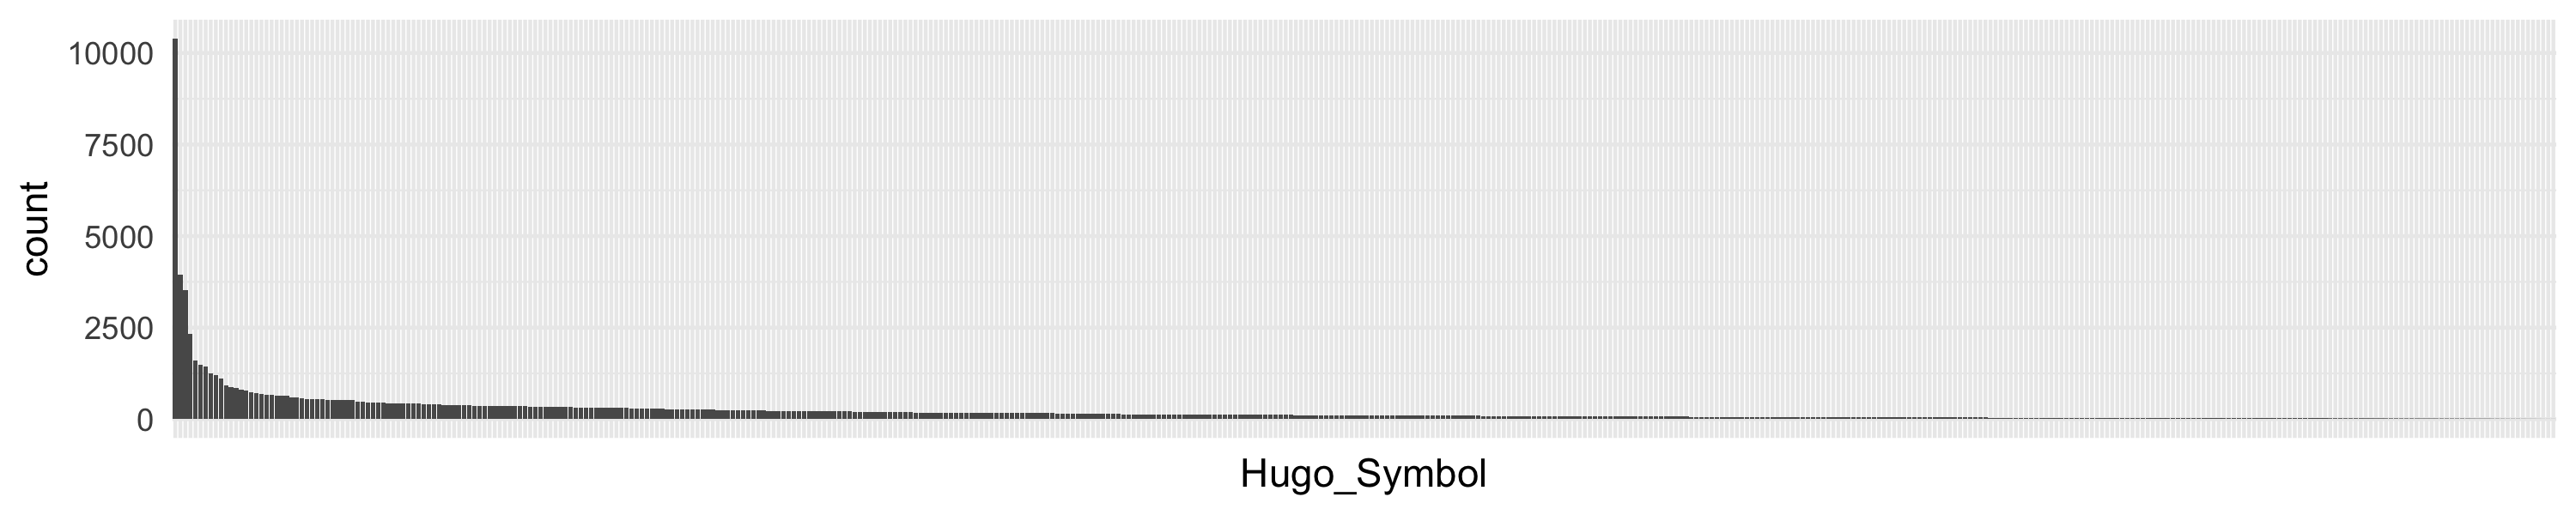

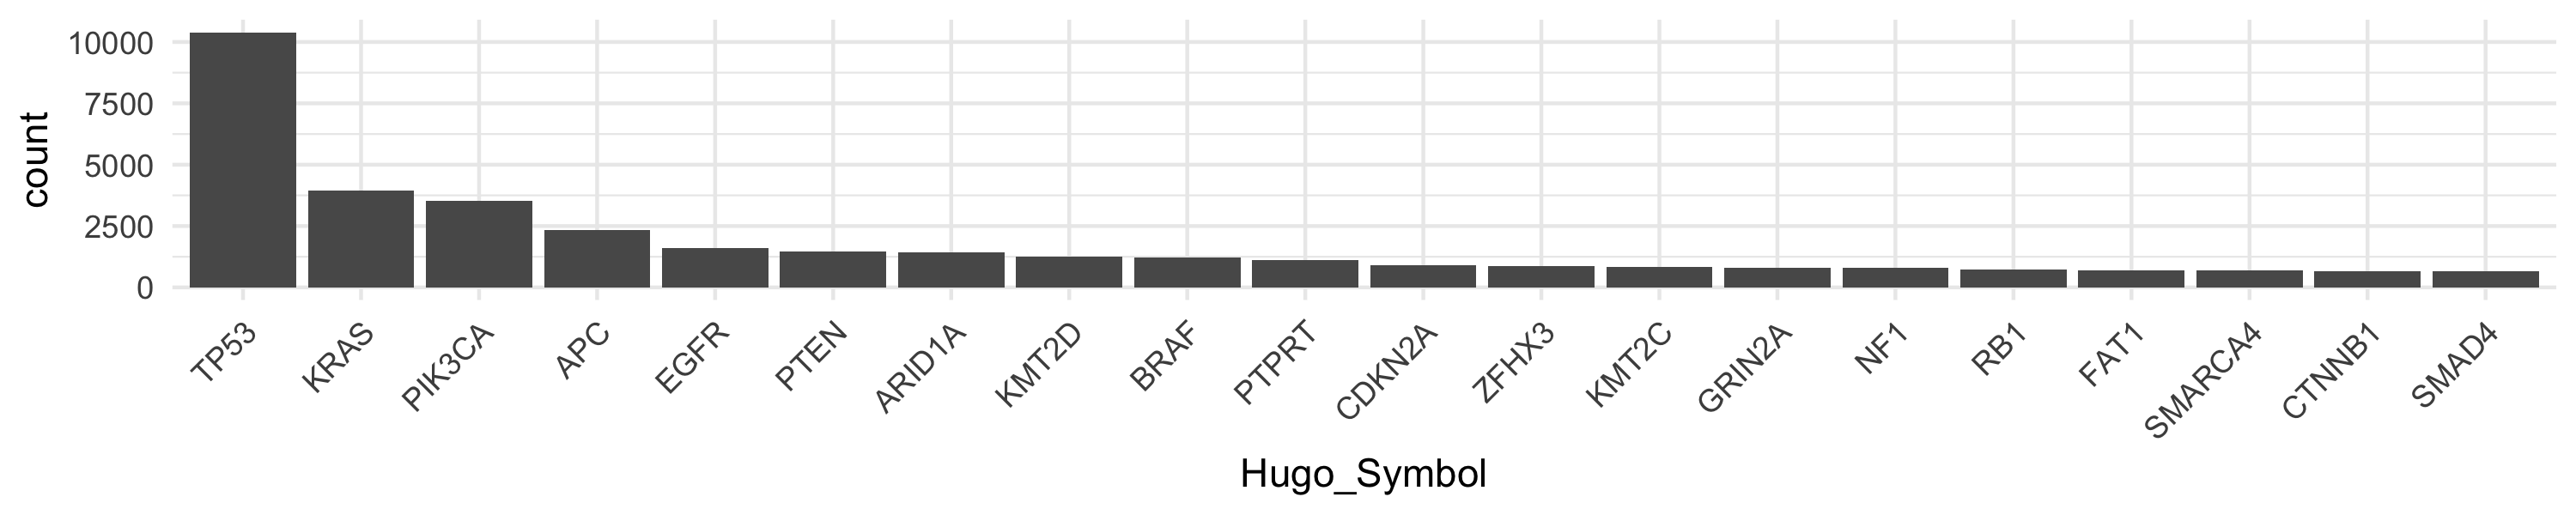

In [32]:
impact_rec <- sort_histogram(impact_rec, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(impact_rec) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(impact_rec, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))